# or: robbing Peter to pay Paul

In this post I'll describe a way to enforce essential boundary conditions when discretizing a PDE using the finite element method.
We'll start out with a simple model problem -- finding the minimizer of the functional

$$J(u) = \int_\Omega\left(\frac{1}{2}k|\nabla u|^2 - fu\right)dx$$

for $u$, subject to the Dirichlet boundary condition

$$u|_{\partial\Omega} = g.$$

Minimizing this quadratic functional is equivalent to finding a weak solution of the Poisson equation.
(If you want to think of this like a heat conduction problem, $k$ is the thermal conductivity, $f$ is the volumetric heating, and $g$ is the temperature of the surrounding medium.)

In most circumstances you'd impose the Dirichlet boundary condition by changing entries of the matrix and right-hand side of the discretized linear system, but futzing with the linear system in this way is very error-prone.
**Nitsche's method is a way to impose essential boundary conditions by instead modifying the variational principle.**

For other problems, there's no good way to impose the essential boundary conditions at all.
An interesting case for me is the Stokes equations for a slow-flowing viscous fluid:

$$J(u, p) = \int_\Omega\left(\frac{1}{2}\tau : \dot\varepsilon - p\nabla\cdot u - f\cdot u\right)dx$$

where $u$ is the fluid velocity vector, $p$ the pressure, $\dot\varepsilon = (\nabla u + \nabla u^\top) / 2$ is the strain rate tensor, and $\tau = 2\mu\dot\varepsilon$ the stress tensor.
Lid-driven cavity flow, where the fluid velocity is set to some specified value at the upper side of the box, is a common benchmark problem.
The case I'm interested in is where we instead have *friction* boundary conditions.
Rather than set the fluid velocity on the boundary, we instead imagine that the fluid is not in perfect contact with its container and that the movement of the lid merely exerts a drag force.
Translating the physics into math gives the following conditions:

$$u\cdot n = 0, \quad (I - n\otimes n)\tau\cdot n = -\kappa(I - n\otimes n)(u - u_\Gamma)$$

on the segment $\Gamma$ of the domain boundary.
These two conditions state that (1) the fluid flows tangential to the boundary and (2) the fluid slides through friction along the boundary, which is moving with speed $u_\Gamma$.
Friction BCs are a little unusual -- they're like a Dirichlet condition in the normal direction and a Robin condition in the tangential directions.
For a curved boundary, we can't impose the normal condition directly and that's where Nitsche's method is a real life-saver.

### The old-fashioned way

Before embarking on any funny business, let's see how to solve the variational problem with Dirichlet BCs in the usual way.
First, we'll use the unit square as our domain, and we'll use basis functions of degree 2.

In [1]:
import firedrake
nx, ny = 32, 32
mesh = firedrake.UnitSquareMesh(nx, ny, diagonal='crossed')
p = 2
Q = firedrake.FunctionSpace(mesh, family='CG', degree=p)

We need to come up with some reasonable right-hand side $f$ and boundary data $g$.
To generate the input data we'll create a Fourier series with random coefficients.
On simple domains like the unit square, you can write down the solution analytically in terms of the coefficients, which makes for a nice sanity check.
In order to guarantee that we can reproduce the results later if need be, we'll explicitly seed the random number generator rather than let the system seed it.

In [2]:
import numpy as np
from numpy import pi as π
from numpy.random import default_rng

x, y = firedrake.SpatialCoordinate(mesh)

rng = default_rng(seed=0)
def random_fourier_series(std_dev, num_modes, exponent):
    from firedrake import sin, cos
    A = std_dev * rng.standard_normal((num_modes, num_modes))
    B = std_dev * rng.standard_normal((num_modes, num_modes))
    expr = sum([(A[k, l] * sin(π * (k * x + l * y)) +
                 B[k, l] * cos(π * (k * x + l * y)))
                / (1 + (k**2 + l**2)**(exponent/2))
                for k in range(num_modes)
                for l in range(int(np.sqrt(num_modes**2 - k**2)))])
    return firedrake.interpolate(expr, Q)

In [3]:
f = random_fourier_series(std_dev=1.0, num_modes=6, exponent=1)
g = random_fourier_series(std_dev=.25, num_modes=5, exponent=1)

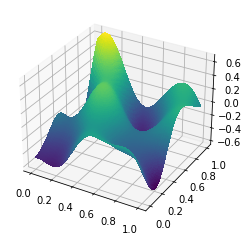

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
firedrake.trisurf(g, axes=axes);

Now we'll form the action functional $J$ and solve for the minimizer.
We have to pass the boundary conditions to the solver explicitly, and internally it will apply these boundary conditions to the solution.

We've also specified that we want to use the sparse direct solver MUMPS for the linear system.
For 2D problems with less than roughly 250,000 unknowns, it's pretty hard to beat direct methods.
On top of that, the goal of the current exercise is to experimenting with different ways to enforce essential boundary conditions, and we should try to eliminate any other possible sources of variability in our solution.
If we used an iterative method like CG, the difference between the solution we'll compute here and the one we'll obtain from Nitsche's method could end up being more a result of a bad preconditioner.
Using direct methods eliminates that possibility.

In [5]:
from firedrake import inner, grad, dx, ds
u = g.copy(deepcopy=True)

J = (0.5 * inner(grad(u), grad(u)) - f * u) * dx
F = firedrake.derivative(J, u)

parameters = {
    'solver_parameters': {
        'ksp_type': 'preonly',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'mumps'
    }
}
bc = firedrake.DirichletBC(Q, g, 'on_boundary')
firedrake.solve(F == 0, u, bc, **parameters)

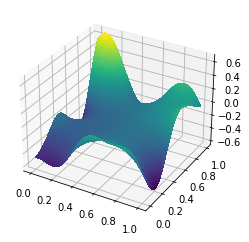

In [6]:
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
firedrake.trisurf(u, axes=axes);

The function `firedrake.solve` takes the Dirichlet boundary conditions as an extra argument and makes all the necessary changes to the linear system for us.
This strategy doesn't work out so well for more complex problems, as I pointed out above for the Stokes equations with friction boundary conditions.
Nonetheless, we'll use the Poisson problem to demonstrate everything in the following.
The fact that we can easily get a ground truth value by directly applying the Dirichlet BCs makes the results fairly easy to analyze after the fact.
Then we'll use the intuition we've built up on this easy problem to attack harder ones.

### The penalty method

The Poisson equation with Dirichlet boundary conditions can be viewed as a constrained optimization problem.
A really blunt way of enforcing these constraints is to modify the variational principle so that departures from the Dirichlet boundary conditions are "expensive" and thus a minimizer will be pretty close to $g$ on the boundary.
The modified variational principle is:

$$J_\gamma(u) = \int_\Omega\left(\frac{1}{2}k|\nabla u|^2 - fu\right)dx + \int_{\partial\Omega}\frac{\gamma k}{2h}(u - g)^2ds.$$

The extra factor of $h$ is a length scale which we need there to make all the physical units work out right, while $\gamma$ is a dimensionless constant.
The penalty method amounts to replacing the Dirichlet boundary condition with the Robin condition

$$-k\frac{\partial u}{\partial n} = \gamma\frac{k(u - g)}{h}.$$

In the limit as $\gamma \to \infty$, the minimizer of $J_\gamma$ will approach the solution of the problem we were originally solving.

For a numerical implementation we'll just take $\gamma$ to be very large and hope for the best.
In our case we'll use

$$\gamma = |\Omega|^{1/d} / h$$

where $|\Omega|$ is the volume of the domain and $h$ is the diameter of a cell of the mesh.

In [7]:
v = g.copy(deepcopy=True)

h = firedrake.CellSize(mesh)
area = firedrake.assemble(firedrake.Constant(1) * dx(mesh))
γ = firedrake.Constant(np.sqrt(area)) / h
J = (0.5 * inner(grad(v), grad(v)) - f * v) * dx + 0.5 * γ / h * (v - g)**2 * ds
F = firedrake.derivative(J, v)

firedrake.solve(F == 0, v, **parameters)

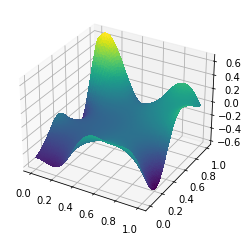

In [8]:
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
firedrake.trisurf(v, axes=axes);

The errors are largest around the boundary of the domain and the magnitudes are appreciably smaller than the spread of the solution itself.

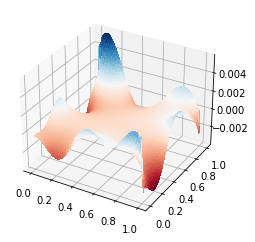

In [9]:
δu = firedrake.interpolate(u - v, Q)

fig = plt.figure()
axes = fig.add_subplot(projection='3d')
firedrake.trisurf(δu, cmap='RdBu', axes=axes);

For comparison later, we'll calculate the relative difference between the exact solution and the solution obtained from the penalty method:

In [10]:
penalty_error = firedrake.norm(u - v) / firedrake.norm(u)
print(penalty_error)

0.004474209285244504


All told this involved very little extra work compared to adding the boundary conditions the traditional way.
There are a number of disadvantages that ultimately make this method undesirable though, most of which can be gleaned from exercise 3.2.2 in Ciarlet's book.
We used a penalty parameter $\gamma$ that scaled like $h^{-1}$ as the mesh is refined (this is in addition to the factor of $h^{-1}$ that was necessary to get the units right).
If the finite element space is asymptotically $\mathscr{O}(h^p)$ accurate, this scaling gives solutions that are only $\mathscr{O}(h^{p/2})$ accurate.
The penalty method effectively negates the greatest advantage of finite element analysis, namely the quasi-optimal accuracy of the solution.

With this scaling, the condition number growth of the linear systems as the mesh is refined is even worse than for the stiffness matrix of the original problem.
In two dimensions, we can partially side-step this issue by solving the linear system with a direct factorization.
Direct methods fare much worse in three dimensions, where iterative methods are a virtual necessity for even modest problem sizes.
The poor conditioning of the penalized problem makes iterative methods take much longer to converge.

### The Lagrange multiplier method

The penalty method is easy to implement, but it can wreck both the accuracy of the solution we obtain and the condition number of the linear system we have to solve.
Instead, we might try to enforce the BC directly by introducing a Lagrange multiplier field $\lambda$ defined on the boundary of the domain.
The Lagrangian is defined as

$$L(u, \lambda) = \int_\Omega\left(\frac{1}{2}k|\nabla u|^2 - fu\right)dx + \int_{\partial\Omega}\lambda(u - g)ds.$$

We could then solve for $u$ and $\lambda$ simultaneously using, say, the Uzawa algorithm.

Unfortunately this approach goes all to hell when we try to discretize it.
The nice part about finite element analysis for the Poisson and related equations is that questions about accuracy of the solution all boil down to approximation theory.
You can use just about any discretization so long as the finite element spaces can approximate $H^1$ in the limit.
All this nice math hinges on the fact that the Poisson equation is positive-definite, but when we introduce a Lagrange multiplier we end up instead with a saddle-point problem.
You can't use just any discretization for a saddle-point problem and there are criteria called the [Ladyzhenskaya-Babuška-Brezzi](https://en.wikipedia.org/wiki/Ladyzhenskaya%E2%80%93Babu%C5%A1ka%E2%80%93Brezzi_condition) condition that tell us when we do (or do not) have a stable discretization.
(The LBB condition is why you need to use Taylor-Hood elements or bubble functions when solving the Stokes equations.)

Ivo Babuška himself proposed this Lagrange multiplier approach for boundary conditions in the 70s but left open the question of which finite element to use for $\lambda$.
Juhani Pitkäranta, in a series of three papers in the 80s, went and solved this problem and found that the stability conditions on the elements for $\lambda$ are so strict as to be almost impossible to implement.
So far as I know, no common FEA packages implement them.

There's still something valuable we can learn from the Lagrange multiplier approach, despite the fact that it isn't practical to use numerically.
Let $u$ and $\lambda$ be the extremum of the Lagrangian $L$; the two fields solve the weak PDE

$$0 = \int_\Omega\left(k\nabla u\cdot\nabla v - fv\right)dx + \int_{\partial\Omega}\lambda v\; ds$$

for all $v$ in $H^1$.
Now suppose that the input data are nice enough for elliptic regularity to apply.
We can push the gradient of $v$ over on $u$:

$$\ldots = -\int_\Omega\left(\nabla\cdot k\nabla u + f\right)v\; dx + \int_{\partial\Omega}\left(\lambda + k\frac{\partial u}{\partial n}\right)v\; ds.$$

In order for this quantity to be 0 for any $v$, regardless of its boundary values, we need for

$$\lambda = -k\frac{\partial u}{\partial n}.$$

In other words, **the Lagrange multiplier is equal to the boundary flux of the solution.**
This is going to be lead us, by of the augmented Lagrangian method, to Nitsche's method.

### The augmented Lagrangian method

In the limit as $\gamma$ gets large, the solution of the penalty method approaches the true solution to the constrained problem.
With a bit of extra analysis it's possible to establish a relation between the penalty and Lagrange multiplier methods.
In the limit as $\gamma \to \infty$, we actually recover what the Lagrange multiplier is from the penalty method:

$$\lambda = -\lim_{\gamma\to\infty}\gamma k(u - g)/h.$$

(You probably have to be careful about whether $h \to 0$ or $\gamma \to \infty$ first but let's... not think about that too hard.)
This suggests some kind of alternative where we use the departure from the constraints to guess the right value of the Lagrange multiplier in the hopes of achieving faster convergence.
When you run with this idea you get the augmented Lagrangian method.

The dumbest description I can think of the augmented Lagrangian method is that you take the penalty method and the Lagrange multiplier method and smash them together:

$$L_\gamma(u, \lambda) = \int_\Omega\left(\frac{1}{2}k|\nabla u|^2 - fu\right)dx + \int_{\partial\Omega}\lambda(u - g)ds + \int_{\partial\Omega}\frac{\gamma k}{2h}(u - g)^2ds.$$

When $u$ satisfies the constraints, the penalty term is exactly 0.
You can think of this modification as adding an extra term to the Lagrangian that doesn't modify the location of the extremum, but which does alter the curvature far from it in a way that's particularly advantageous.

The payoff for adopting this approach is that we can get a solution $u$ that exactly satisfies the constraints but without taking $\gamma \to \infty$.
Consequently we don't blow up the condition number like we do for the penalty method.
On top of that, there's a simple and convergent iterative procedure to update both $\gamma$ and $\lambda$ for which we only solve a positive-definite linear system at each step.

For the penalty method, you get the best accuracy by making $\gamma$ asymptotic to some power of $h^{-1}$.
At this point it would be tempting to try and carry out the same analysis for the augmented Lagrangian method.
Instead, we'll use the fact that $\lambda$ is equal to the boundary flux in equilibrium to eliminate this variable entirely, leading us to

### Nitsche's method

The variational principle for Nitsche's method is obtained by substituting the analytical expression for the Lagrange multiplier $\lambda$ into the augmented Lagrangian:

$$J_\gamma(u) = \int_\Omega\left(\frac{1}{2}k|\nabla u|^2 - fu\right)dx - \int_{\partial\Omega}k\frac{\partial u}{\partial n}(u - g)ds + \int_{\partial\Omega}\frac{\gamma k}{2h}(u - g)^2ds.$$

The extra terms are both 0 at a solution of the original variational problem with the boundary conditions we specified.
So a critical point of $J_\gamma$ is also a solution, but I say critical point because we haven't proved yet that this functional is convex.
Whether or not it's convex will hinge on our choice of the penalty parameter $\gamma$, and with a little elbow grease we can figure out exactly how big the penalty needs to be.

We want to show that the Nitsche functional has the same positivity properties as the original functional.
This means showing that its second derivative is a strictly positive-definite operator, in other words that

$$\langle d^2J_\gamma\cdot v, v\rangle = \int_\Omega k|\nabla v|^2dx - 2\int_{\partial\Omega}k\frac{\partial v}{\partial n}v\; ds + \int_{\partial\Omega}\frac{\gamma k}{h}v^2ds > 0$$

any $v$ in $H^1$.
For our purposes, proving that the Hessian of $J_\gamma$ is positive-definite is easiest because it's twice-differentiable.
There are several other definitions of convexity that can be easier to work from depending on the scenario, like if the functional isn't differentiable everywhere.
The important point is that convexity guarantees the existence and uniqueness of a solution.
From there we can prove the norm-equivalence properties that make finite element analysis possible.

#### A first (failing) attempt

The middle term of the last equation is clearly the troublesome part, while the remaining two terms are manifestly positive.
As a first guess, we'll try using Young's inequality:

$$2ab \le a^2 + b^2.$$

By applying this to the middle term, we can break it up into a sum of two boundary integrals that hopefully can be controlled:

$$2\int_{\partial\Omega}k\frac{\partial v}{\partial n}v\; ds \le \int_{\partial\Omega}k\left(\frac{\partial v}{\partial n}\right)^2ds + \int_{\partial\Omega}kv^2\; ds.$$

The second term of the last equation looks like something that we can control with the boundary penalty, but the first term is a little harder to crack.
If we know that $v$ is in $H^1(\Omega)$, then the Sobolev trace inequality tells us that $v|_{\partial\Omega}$ is in the [Slobodeckij space](https://en.wikipedia.org/wiki/Sobolev_space#Sobolev%E2%80%93Slobodeckij_spaces) $H^{1/2}(\partial\Omega)$.
We can then show that $\partial v/\partial n$ is in the dual space $H^{-1/2}(\partial\Omega)$, but to control the boundary flux norm in the last equation we would at the very least need that it's in $L^2(\partial\Omega)$.
That might be true but only if we assume a greater degree of regularity from the get-go.
You could also guess that the last expression is a load of bunk because the physical units don't come out right!

#### Inverse inequalities

Using Young's inequality isn't totally far off, we just need to apply a slightly different form of it.
Before doing that, however, I need to introduce a finite element **inverse inequality**.
Inverse inequalities apply only to polynomials and not to all of $H^1$.
These results are still useful to us because the basis functions in finite element analysis are polynomials.
Moreover, we'll assume that the domain $\Omega$ has been subdivided into a regular mesh of elements $\{E_i\}$ where each $E_i$ is a triangle or tetrahedron.

What's interesting about inverse inequalities is that they control things in the opposite direction from what you expect.
For example, the Poincaré inequality states that, if $v$ is in $H^1$ and $v|_{\partial\Omega} = 0$, then

$$\int_\Omega v^2dx \le C\int_\Omega|\nabla v|^2dx.$$

The corresponding inverse inequality states that, if $v$ is a polynomial of degree $p$ on a simplex $E$, then

$$\int_E|\nabla v|^2dx \le h^{-2}C(d, p, E)\int_E v^2dx$$

where $h$ is the radius of the simplex $E$ and $C$ is a constant that depends on the dimension $d$, the polynomial degree $p$, and the shape regularity of $E$, but not on $v$.
This inequality does not imply the ridiculous conclusion that the $H^1$ norm can be bounded by the $L^2$ norm as we refine a finite element mesh. 
The factors $h^{-2}$ would blow up as the cells get smaller and smaller.

The particular inverse inequality that we'll need states that, if $v$ is a polynomial of degree $p$, then its square norm on the boundary can be controlled by the norm over the interior:

$$\int_{\partial E}v^2ds \le C(d, p)\cdot\frac{|\partial E|}{|E|}\cdot\int_E v^2dx$$

where $|E|$, $|\partial E|$ are respectively the volume of the simplex and the area of its boundary.
Using a bit of trigonometry we can show that, for a triangle with shortest side length $h$ and smallest angle $\theta$,

$$\frac{|E|}{|\partial E|} \ge \sin\theta\cdot\tan\theta/2\cdot h/2.$$

We can calculate $\theta$ explicitly by looping over all the triangles of the mesh, or we can rely on the fact that nowadays mesh generators guarantee that the minimum angle is greater than, say, $\pi / 12$.

The usual approach to proving these inverse inequalities (for example, in Ciarlet's book) is to note that the space of polynomials up to a given  degree is finite-dimensional and that all norms on finite-dimensional vector spaces are equivalent.
This proof strategy does not, however, give any clue as to what the constant $C$ might be.
You can figure out exactly what the constant is for piecewise linear finite elements on triangles, but it would be a lot nicer if we could compute a sharp bound that would work for any degree.
In a wonderfully readable paper from 2003, Warburton and Hesthaven showed that, for a polynomial $u$ of degree $p$ on a simplex $E$ in $d$ dimensions,

$$\int_{\partial E}u^2ds \le \frac{(p + 1)(p + d)}{d}\cdot\frac{|\partial E|}{|E|}\cdot\int_Eu^2dx.$$

The proof relies on the fact that orthogonal polynomials on a simplex can be expressed in terms of Jacobi polynomials.

We're more interested in controlling the gradient of $v$ on the boundary rather than the values of $v$ itself.
We can still use the boundary inverse inequality by noting that $\nabla v$ is a polynomial of one lower degree and with $d$ components:

$$\int_{\partial E}\left(\frac{\partial v}{\partial n}\right)^2ds \le d\cdot C(d, p - 1)\cdot\frac{|\partial E|}{|E|}\cdot\int_E|\nabla v|^2dx \ldots$$

and by applying both the trigonometric bound for the surface-to-volume ratio and the explicit formula for the constant $C$ we get that

$$\ldots \le 2p\cdot(p + d - 1)\cdot\csc\theta\cot\theta/2\cdot h^{-1}\cdot \int_E|\nabla v|^2dx.$$

The extra factor of $h$ is what we were missing before when we tried to apply Young's inequality.
From now on we'll write the constant in the last inequality as $C(d, p, \theta)$.
The important point to note is that $C(d, p, \theta)$ increses to infinity as $\theta$ approaches 0, so the more regular the mesh the better.

#### The Peter-Paul inequality

The inverse inequality suggests that we can indeed control the norm of the boundary flux, but we need to sneak in an extra factor of $h$ in order to be able to use it.
That's where the famous "Young's inequality with $\epsilon$" comes in.
This inequality is also called the **Peter-Paul inequality** after the English expression "robbing Peter to pay Paul"; the expression dates from the middle ages when the assets and properties of St. Peter's Cathedral in London were siphoned off to pay for the repairs and upkeep of St. Paul's Cathedral.

Historical anecdotes aside, the Peter-Paul inequality is:

$$2ab \le \underbrace{\epsilon^{-1}a^2}_{\text{Peter}} + \underbrace{\epsilon b^2}_{\text{Paul}}.$$

where $\epsilon$ is an arbitrary positive number.
If we make $\epsilon$ very small then we can control one term at the expense of making the other very large.
We'll take $\epsilon$ to also include a factor of $h$, and use it to break up the troublesome term in the Nitsche functional:

$$2\int_{\partial\Omega}k\frac{\partial v}{\partial n}v\; ds \le \epsilon\int_{\partial\Omega}hk\left(\frac{\partial v}{\partial n}\right)^2ds + \epsilon^{-1}\int_{\partial\Omega}\frac{k}{h}v^2\; ds.$$

We haven't decided what $\epsilon$ needs to be yet; it relates to the constant $C$ in the inverse inequality.
I should also be more specific about $h$.
Assuming that $\Omega$ has been divided into triangles $\{E_i\}$, we'll define $h$ to be equal to

$$h = \sum_i \text{diameter}(E_i)\cdot \mathbb{1}_{E_i}$$

where $\mathbb{1}_A$ is the indicator function of the set $A$.
In other words the function $h$ gives the local element diameter.
The important point here is that $h$ depends on position and consequently needs to live inside the integrals and not out.

Now that we have the extra factor of $h$ we can apply the inverse inequality.
There's a little extra work to account for the presence of the nonhomogeneous conductivity coefficient $k$ in our variational problem.
For the problem to be well-posed we need that $k$ is bounded above and below by positive constants.
From the original form of the inverse inequality, we can then take a few extra steps to arrive at the following:

$$\int_{\partial\Omega}kh\left(\frac{\partial v}{\partial n}\right)^2ds \le C(d, p, \min\theta)\cdot\frac{\max_\Omega k}{\min_\Omega k}\cdot\int_\Omega k|\nabla v|^2dx.$$

We could pull the ratio of the maximum of $k$ to the minimum inside the integral and calculate it over each cell instead over the whole domain if we needed an even tighter inequality.
For example if there were large contrasts in $k$ over the whole domain but not over a single element then that could be a big improvement.
Likewise, we could also pull the constants $C(d, p, \theta)$ inside the integral, which we would then express as a sum over the intersections of $\partial\Omega$ with each cell.
For highly anisotropic meshes, it might be worthwhile to keep the constants inside the sum, but in the interest of simplicity we'll leave this as-is.

The last inequality tells us exactly how small $\epsilon$ needs to be:

$$\epsilon = \alpha\cdot C(d, p, \min\theta)^{-1}\cdot\frac{\min_\Omega k}{\max_\Omega k}$$

for some constant $\alpha$ such that $0 < \alpha < 1$.
When we go to compute things we'll take $\alpha = 1/2$, but for now we'll leave it arbitrary.
Finally, we can put everything together:

$$\begin{align}
\langle d^2J_\gamma\cdot v, v\rangle & = \int_{\Omega}k|\nabla v|^2dx - 2\int_{\partial\Omega}k\frac{\partial v}{\partial n}v\;ds + \int_{\partial\Omega}\frac{\gamma k}{h}v^2ds
\\ 
& \underset{\text{Peter-Paul}}{\ge} \int_{\Omega}k|\nabla v|^2dx - \epsilon\int_{\partial\Omega}hk\left(\frac{\partial v}{\partial n}\right)^2ds + \int_{\partial\Omega}\frac{(\gamma - \epsilon^{-1})k}{h}v^2ds \\
& \underset{\text{inverse ineq.}}{\ge} (1 - \alpha)\int_{\Omega}k|\nabla v|^2dx + \int_{\partial\Omega}\frac{(\gamma - \epsilon^{-1})k}{h}v^2ds.
\end{align}$$

The last inequality now tells us how big we need to take the penalty parameter $\gamma$:

$$\gamma > \epsilon^{-1} = \alpha^{-1}C(d, p, \min\theta)\frac{\max_\Omega k}{\min_\Omega k}.$$

Again for definiteness sake we can set $\gamma = \alpha^{-1}\epsilon^{-1}$ when we go to compute things.

Let's recap things a bit.
First, we broke up the troublesome middle term using the Peter-Paul inequality.
This middle term gets broken up into the square norm of a boundary flux and the square norm of a boundary value.
We can control the boundary flux in terms of the square norm of the interior flux by using a finite element inverse inequality.
In order to "pay Paul", we wedge in an extra factor of $h$ in Young's inequality.
But we can't pay Paul without "robbing Peter" when we weight the boundary value integral by $h^{-1}$.
After that a judicious choice of the penalty parameter $\gamma$ ensures that everything is positive, which implies convexity and therefore well-posedness.

### Demonstration

Almost all the pieces that we need to implement this are part of UFL.
The only extra factor is determining the shape regularity of each triangle.

In [11]:
from numpy.linalg import norm

coords = mesh.coordinates.dat.data_ro
cells = mesh.coordinates.cell_node_map().values

θ = np.inf
for cell in cells:
    for k in range(3):
        x, y, z = coords[np.roll(cell, k)]
        ζ, ξ = y - x, z - x
        angle = np.arccos(np.inner(ζ, ξ) / (norm(ζ) * norm(ξ)))
        θ = min(angle, θ)
        
print("Minimum angle: {} * π".format(θ / π))

Minimum angle: 0.25000000000000006 * π


From here we can easily define the modified variational principle for Nitsche's method.
We've chosen $\alpha = 1/2$ in this case, in which case the boundary penalty gets weighted by $\alpha^{-2}$.

In [12]:
v = g.copy(deepcopy=True)

h = firedrake.CellSize(mesh)
n = firedrake.FacetNormal(mesh)

J_interior = (0.5 * inner(grad(v), grad(v)) - f * v) * dx
J_flux = -inner(grad(v), n) * (v - g) * ds
J_penalty = 0.5 * (v - g)**2 / h * ds

α = 1/2
C = p * (p + 1)
γ = firedrake.Constant(C / α**2 / (np.sin(θ) * np.tan(θ/2)))
J = J_interior + J_flux + γ * J_penalty

F = firedrake.derivative(J, v)
firedrake.solve(F == 0, v, **parameters)

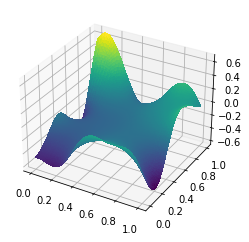

In [13]:
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
firedrake.trisurf(v, axes=axes);

The error is smaller than that of the pure penalty method by a factor of 1000!
On top of that, we were able to achieve this improvement with a penalty $\gamma$ that's a constant as the mesh is refined.
For the pure penalty method, $\gamma$ scales like $h^{-1}$, which makes the condition number for the linear system much worse as the mesh is refined.
Nitsche's method, by contrast, has the same asymptotic condition number growth as the original problem.

In [14]:
nitsche_error = firedrake.norm(u - v) / firedrake.norm(u)
print(nitsche_error / penalty_error)

0.0012195126881258055


Having a sharp estimate for the constant in the inverse inequality enabled us to set the penalty parameter without any guesswork or hand-tuning.
Most of the papers I've found on Nitsche's method completely gloss over this point, but I think the ability to set parameters like this with no intervention on the part of an end user is essential if your goal is to deliver code to domain scientists.
Say you're developing a package for modeling groundwater flow; you should not go expecting hydrologists to know or care about the details of how you implemented the boundary conditions, they should just work.